This file works primarily to query information about fume hood usage on campus. Calculating fume hood energy usage can be roughly simplified by the following formula:

BTU/hr = 1.08 * CFM * (Th-Tl)

CFM represents the cubic feet per minute of air passing through a fume hood. Th is the temperature of the room, Tl is the temperature of outdoors. We will update this script for fume hood energy usage during periods of cooling later.


Thermodynamics for Calculating Energy Usage When Cooling Air:
Enthalpy: Total heat content of a system
- NO change in volume of the air within the fumehood
- We don't know the mass of hte air
- Use specific enthalpy (J/m)
- h = u + Pv
- Assume no work is done by the system.
- delta_h = cp * delta_T
- If delta_h > 0, energy was gained by the system
- If delta_h <0, energy was lost by the system
- #biotech_oa_conditions/temperature

In [4]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timezone
import requests
import json
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import statistics as stat

In [5]:
def create_tuple(response):
    # all data
    response_data = response.json()
    # print(response_data)
    # data for a single target
    response_datum = response_data[0]
    #print(response_datum)
    # the target - e.g. "120MapleAve.STM.M22-V/AverageMassFlow"
    response_target = response_datum['target']
    # the metric for this target - e.g. "Steam"
    #response_metric = response_datum['metric']
    # print(response_metric)
    # the datapoints as a list of lists
    response_datapoints = response_datum['datapoints']
    #print(response_datapoints)
    # array of tuples for numpy
    tuple_array = [tuple(x) for x in response_datapoints]
    # make a numpy array
    npa = np.array(tuple_array, dtype=[
                   ('value', np.double), ('ts', 'datetime64[ms]')])
    # for index, i in enumerate(npa):
    #   j = pd.to_datetime(i[1]).replace(tzinfo=timezone.utc).astimezone(tz="America/New_York")
    #   npa[index][1] = j
    return npa

In [6]:
def current_date():
    return str(datetime.now())

In [7]:
"""
Returns an array of tuples where tuple[0] is the metric, and tuple[1] is the time 
of measurement

Target: a WebCTRL point name in the form of a string 
Example: "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log"

Server: a string representing the WebCTRL server our point exists in
Example: "biotech_main"

Start: the start time we wish to be querying data about (in string format)
Example: "2021-12-31T11:00Z"

End: The end time we wish to be querying data about
Example: "2022-12-31T11:00Z"
"""
def fume_query(target,server, start,end):
  url = "https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query"
  data = {
      "range": {
        "from": start,
        "to": end,
      },
      "targets": [
        {
          "payload": {
            "schema": server,
          },
          "target": target
        }
      ],

    }
  request = requests.post(url, json=data)
  print(request)
  # print(request.json())
  return create_tuple(request)

fume_query(target="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash", server="biotech_main", start="2021-12-25T00:00:00.000", end=current_date())
# fume_query(target="#baker_west_lab_120/occ_sensor_trend", server="endowed_main", start="2021-12-25T00:00:00.000", end=current_date())

# fume_query(target="#lstb_b-07_north/fh_sash_pos", server="weill_main", start="2022-10-22T11:00Z", end="2022-10-22T11:05Z")
# fume_query(target="#baker_west_lab_120/fh_sash_pos", server="endowed_main", start="2022-10-10T11:00Z", end="2022-10-22T11:05Z")

<Response [200]>


array([(3.5, '2021-12-25T05:00:00.000'), (3.5, '2021-12-25T05:05:00.000'),
       (3.5, '2021-12-25T05:10:00.000'), ...,
       (1.2, '2023-03-20T14:45:00.000'), (1.2, '2023-03-20T14:50:00.000'),
       (1.2, '2023-03-20T14:55:00.000')],
      dtype=[('value', '<f8'), ('ts', '<M8[ms]')])

In [8]:
"""
Returns a time series of the ithaca air temperature over the respective 
"""

def outside_temp(start,end):
  # https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query doesn't work
  # https://portal.emcs.cornell.edu/api/datasources/proxy/5/query works
  # https://portal-api.emcs.cucloud.net/query works
  url = "https://portal-api.emcs.cucloud.net/query"
  target = "GameFarmRoadWeatherStation.TAVG_H_F"
  data = {
    "range": {
        "from": start,
        "to": end
    },
    "targets": [
        {
            "payload": {
                "additional": [
                    "noagg",
                ]
            },
            "target": target,
        }
    ]
  }
  request = requests.post(url, json=data)
  print(request)
#   print(request.json())
  return create_tuple(request)

In [9]:
"""
A switch in the energy calculations that allows us to avoid issues between times of years where it is hotter/colder outside.
"""

def coldorhot(cfm,external,internal):
    if external<=internal:
        #sensible heating equation
        return 1.08 * cfm * (internal - external)
    if external>internal:
        #enthalpy of air
        return 0.24 * cfm /13.333 * 60 * (external - internal)



In [12]:
from datetime import datetime
from dateutil import parser
import matplotlib.dates as mdates

def updatedquery(target_list, server, start, end):
    cfm_points = fume_query(target_list[0],server,start,end)
    sash_points = fume_query(target_list[3],server,start,end)
    occ_points = fume_query(target_list[2],server,start,end)
    internal_temp_points = fume_query(target_list[1],server,start,end)
    external_temp_points = fume_query("#biotech/ground_flr_mech/building_hydronic_heating_syatems/reheat_heat_exchanger/oat",server,start,end)
    #external_temp_master = outside_temp(start,end)

    cfm_list = pd.Series(data=[i[0] for i in cfm_points], index=[i[1] for i in cfm_points])
    cfm_list = cfm_list[~cfm_list.index.duplicated()]

    sash_list = pd.Series(data=[i[0] for i in sash_points], index=[i[1] for i in sash_points])
    sash_list = sash_list[~sash_list.index.duplicated()]


    occ_list = pd.Series(data=[i[0] for i in occ_points], index=[i[1] for i in occ_points])
    occ_list = occ_list[~occ_list.index.duplicated()]


    internal_temp_list = pd.Series(data=[i[0] for i in internal_temp_points], index=[i[1] for i in internal_temp_points])
    internal_temp_list = internal_temp_list[~internal_temp_list.index.duplicated()]

    external_temp_list = pd.Series(data=[i[0] for i in external_temp_points], index=[i[1] for i in external_temp_points])
    external_temp_list = external_temp_list[~external_temp_list.index.duplicated()]

    #external_temp_list = pd.Series(data=[i[0] for i in external_temp_master], index=[i[1] for i in external_temp_master])
    # print("\nExternal Temp List: ", external_temp_list)
    # external_temp_list = pd.read_csv("C:\\Users\\Rob\\Documents\\GitHub\\fume-hood-dashboard\\game_farm\\hist.csv", index_col=0).squeeze()
    # external_temp_list.index = external_temp_list.index.astype('datetime64[ns]')

    df = pd.concat([cfm_list, sash_list, occ_list, internal_temp_list, external_temp_list], axis=1)
    df.columns = ["cfm", "sash" ,"occ", "internal temp", "external temp"]


    #Where the energy calculations happen
    df['BTUh'] = df.apply(lambda df: coldorhot(df['cfm'], df['external temp'], df['internal temp']), axis=1)
    df = df.dropna()
    return df



target_list = ["#biotech/biotech_1st_floor/first_floor_fume_hood_lab_spaces/lab_147b_control/hoodvalve_flow/trend_log",
               "#biotech/biotech_1st_floor/first_floor_fume_hood_lab_spaces/lab_147b_control/zone/zone_temp/trend_log",
               "#biotech/biotech_1st_floor/first_floor_fume_hood_lab_spaces/lab_147b_control/occ_trend",
               "#biotech/biotech_1st_floor/first_floor_fume_hood_lab_spaces/lab_147b_control/hood_sash"]
server = "biotech_main"

#One month of data
start = str(datetime(2021, 1, 1))
end = str(datetime(2022, 12, 30))

df = updatedquery(target_list,server,start,end)
display(df)


<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


,cfm,sash,occ,internal temp,external temp,BTUh


In [9]:
#Let's Look at How energy was Used Over Time for 2022

# print(df.loc["2021-06-19 03:15:00"])
#
# plt.plot(df["BTUh"], label="BTUh")
# plt.ylabel("Energy Usage in BTUh")
# plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(plt.gca().xaxis.get_major_locator()))
# plt.title("Energy Usage (BTUh) vs. Time")
# plt.show()

In [10]:
#Exploratory Data Visualizations

#Let's look at seasonality first
#We will need to add month, day, etc to eventually add season
df["month"] = df.index.month
df["day"] = df.index.day

def season(month):
    if month in [12,1,2]:
        return 0
    if month in [3,4,5]:
        return 1
    if month in [6,7,8]:
        return 3
    return 2
df['Season'] = df.apply(lambda df: season(df['month']), axis=1)
display(df)

corr = df[['BTUh','occ','Season']].corr()
corr

#plt.plot(df['Season'], df['BTUh'])

,cfm,sash,occ,internal temp,external temp,BTUh,month,day,Season
2022-01-01 05:00:00,224.62,1.8,0.0,70.5,47.6,5555.30184,1,1,0
2022-01-01 05:15:00,226.57,1.8,0.0,70.4,47.5,5603.52924,1,1,0
2022-01-01 05:30:00,224.62,1.8,0.0,70.3,47.7,5482.52496,1,1,0
2022-01-01 05:45:00,224.13,1.8,1.0,70.3,47.6,5494.77108,1,1,0
2022-01-01 06:00:00,226.08,1.8,1.0,70.6,47.4,5664.66048,1,1,0
...,...,...,...,...,...,...,...,...,...
2022-12-31 03:45:00,224.13,1.2,0.0,70.6,51.6,4599.14760,12,31,0
2022-12-31 04:00:00,224.62,1.2,0.0,70.6,51.6,4609.20240,12,31,0
2022-12-31 04:15:00,225.10,1.2,0.0,70.5,51.6,4594.74120,12,31,0
2022-12-31 04:30:00,225.10,1.2,0.0,70.4,51.4,4619.05200,12,31,0


,BTUh,occ,Season
BTUh,1.000000,-0.049376,-0.751543
occ,-0.049376,1.000000,0.012774
Season,-0.751543,0.012774,1.000000


In [11]:
###Statistical Test for whether the mean energy usage during working hours is equal to mean energy usage during non-working hours

#How do we break the data into the needed time chunks?

#1 means working
#0 means after hours
def workingtime(time,month):
    if time >=8 and time <=18 and month in [9,10,11,12,2,3,4,5]:
        return 1
    return 0
df['hour'] = df.index.hour
df['Working'] = df.apply(lambda df: workingtime(df['hour'],df["month"]), axis=1)
display(df)

#Energy usage while working
energy_working = df.loc[df['Working'] == 1, 'BTUh'].sum()
total_num_w =  df.loc[df['Working'] == 1, 'Working'].sum()
mean_ew = energy_working/total_num_w
var_ew = stat.variance(df.loc[df['Working'] == 1, 'BTUh'])


#Energy usage while not working
energy_non_working = df.loc[df['Working'] == 0, 'BTUh'].sum()
total_num_nw = len(df["Working"]) - total_num_w
mean_nw = energy_non_working/total_num_nw
var_nw = stat.variance(df.loc[df['Working'] == 0, 'BTUh'])

aggregated_var = (((total_num_w-1)*var_ew)+((total_num_nw-1)*var_nw))/(total_num_w+total_num_nw-2)

t = (mean_ew-mean_nw)/(math.sqrt(aggregated_var*((1/total_num_w)+(1/total_num_nw))))



#Critical Value
crit = st.t.ppf(0.95,total_num_w+total_num_nw-2)


print(energy_working)
print(energy_non_working)

print(mean_ew)
print(mean_nw)

print(t)
print(crit)

#Reject the null hypothesis. 

#Something weird is going on here
#The total energy across the year during "non-working" hours is greater than during working hours
#But the mean energy usage is greater during "working hours"
#Hypothesis: Maybe there isn't a lot of people working over the summer to justify working hours being true across the whole year??

,cfm,sash,occ,internal temp,external temp,BTUh,month,day,Season,hour,Working
2022-01-01 05:00:00,224.62,1.8,0.0,70.5,47.6,5555.30184,1,1,0,5,0
2022-01-01 05:15:00,226.57,1.8,0.0,70.4,47.5,5603.52924,1,1,0,5,0
2022-01-01 05:30:00,224.62,1.8,0.0,70.3,47.7,5482.52496,1,1,0,5,0
2022-01-01 05:45:00,224.13,1.8,1.0,70.3,47.6,5494.77108,1,1,0,5,0
2022-01-01 06:00:00,226.08,1.8,1.0,70.6,47.4,5664.66048,1,1,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 03:45:00,224.13,1.2,0.0,70.6,51.6,4599.14760,12,31,0,3,0
2022-12-31 04:00:00,224.62,1.2,0.0,70.6,51.6,4609.20240,12,31,0,4,0
2022-12-31 04:15:00,225.10,1.2,0.0,70.5,51.6,4594.74120,12,31,0,4,0
2022-12-31 04:30:00,225.10,1.2,0.0,70.4,51.4,4619.05200,12,31,0,4,0


64194392.62108481
118734975.37366794
6053.790326394267
4883.198658180873
24.911933894443084
1.6448972678662719


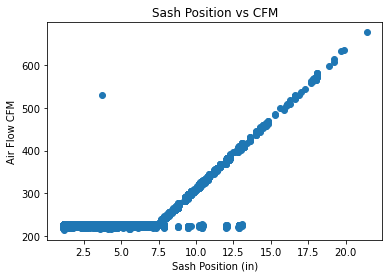

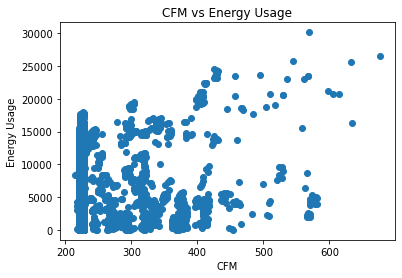

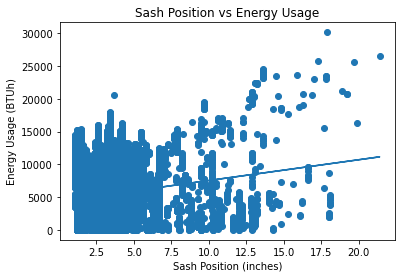

(0.17029038155331544, 1.883644089668346e-225)


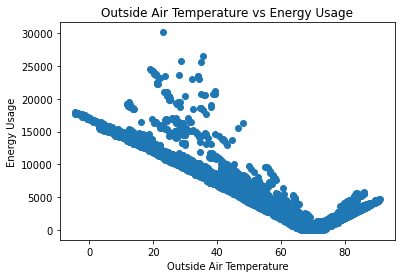

In [12]:

plt.scatter(df["sash"], df["cfm"])
plt.title("Sash Position vs CFM")
plt.xlabel("Sash Position (in)")
plt.ylabel("Air Flow CFM")
plt.show()

plt.scatter(df["cfm"],df["BTUh"])
plt.title("CFM vs Energy Usage")
plt.xlabel("CFM")
plt.ylabel("Energy Usage")
plt.show()

plt.scatter(df["sash"],df["BTUh"])
m, b = np.polyfit(df["sash"], df["BTUh"], 1)
plt.plot(df["sash"], m*df["sash"] + b)
plt.title("Sash Position vs Energy Usage")
plt.xlabel("Sash Position (inches)")
plt.ylabel("Energy Usage (BTUh)")
plt.show()

plt.scatter(df["external temp"],df["BTUh"])
plt.title("Outside Air Temperature vs Energy Usage")
plt.xlabel("Outside Air Temperature")
plt.ylabel("Energy Usage")

pearson_r = st.pearsonr(df["sash"],df["BTUh"])
print(pearson_r)
plt.show()
ndf = (df[df["BTUh"]>12000])



Text(0, 0.5, 'Average BTUh')

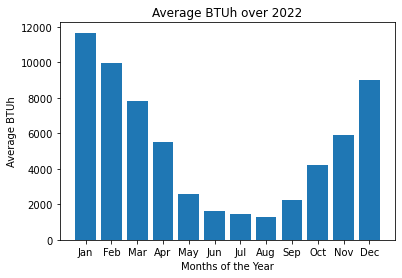

In [13]:
#Month Graph
def get_average_energy_by_month(df, month):
    ndf = df.loc[df['month']==month]
    return np.mean(ndf["BTUh"])

def get_average_occupancy_by_month(df,month):
    ndf = df.loc[df['month']==month]
    return np.mean(df['month'])

def get_average_metric(df,month,met):
    ndf = df.loc[df['month']==month]
    return np.mean(ndf[met])


#averages = [get_average_energy_by_month(df,i) for i in range(1,13)]
averages = [get_average_metric(df,i,"BTUh") for i in range(1,13)]

average_occ = [get_average_metric(df,i,"occ") for i in range(1,13)]

months = ["Jan", "Feb", "Mar", "Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

fig = plt.bar(x = months, height=averages)
plt.title("Average BTUh over 2022")
plt.xlabel("Months of the Year")
plt.ylabel("Average BTUh")
#plt.savefig("C:\\Users\\Rob\\Desktop\\ESW\\Fume\\Images\\energy_bar_graph.png",dpi=500)




#ndf.to_csv("C:\\Users\\Rob\\Desktop\\ESW\\Fume\\jun.csv")



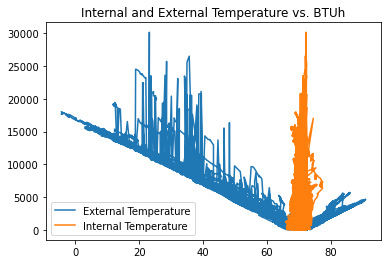

In [14]:
plt.plot(df["external temp"],df["BTUh"],label="External Temperature")
plt.plot(df["internal temp"],df["BTUh"], label = "Internal Temperature")
plt.title("Internal and External Temperature vs. BTUh")
plt.legend(loc="lower left")
plt.show()

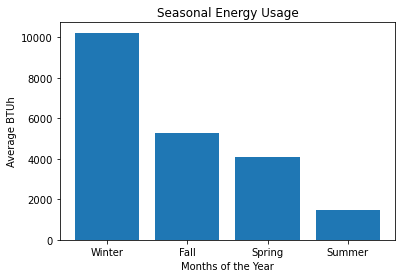

In [15]:
seasons = ["Winter", "Fall","Spring","Summer"]
energies = []
for i in range(0,4):
    ndf = df.loc[df["Season"]==i]
    energies.append(np.mean(ndf["BTUh"]))

plt.bar(x=seasons,height=energies)
plt.title("Seasonal Energy Usage")
plt.ylabel("Average BTUh")
plt.xlabel("Months of the Year")
plt.show()



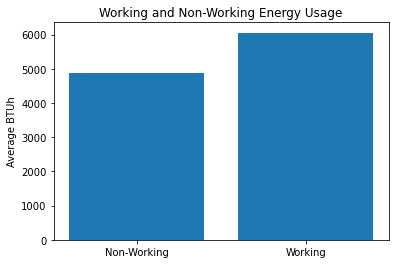

In [16]:
energy_working = [np.mean(df.loc[df['Working'] == 0]["BTUh"]), np.mean(df.loc[df['Working'] == 1]["BTUh"])]
labels = ["Non-Working","Working"]
plt.bar(x=labels, height=energy_working)
plt.title('Working and Non-Working Energy Usage')
plt.ylabel('Average BTUh')
plt.show()

In [17]:
#Correlate against Academic Calendar

import calendar
import numpy as np

#calendar.prcal(2023)



cal = calendar.Calendar()
days = cal.itermonthdays4(2022,1)
# for i in days:
#     print(i)

#Create time intervals of when school is in session

#np.is_busday() is a useful function to determine if a day is a business day or not

#Calendar for 2022

#Spring semester
first_day_spring = np.datetime64('2022-01-24')
feb_break_start = np.datetime64('2022-02-26')
feb_break_end = np.datetime64('2022-03-01')
spring_break_start = np.datetime64('2022-04-02')
spring_break_end = np.datetime64('2022-04-10')
last_day_spring = np.datetime64('2022-05-20')

#Fall semester
first_day_fall = np.datetime64('2022-08-22')
labor_day = np.datetime64('2022-09-05')
fall_break_start = np.datetime64('2022-10-08')
fall_break_end = np.datetime64('2022-10-11')
thanksgiving_start = np.datetime64('2022-11-23')
thanksgiving_end = np.datetime64('2022-11-27')
last_day_fall = np.datetime64('2022-12-17')

def is_a_school_day(time):
    #Spring semester
    first_day_spring = np.datetime64('2022-01-24')
    feb_break_start = np.datetime64('2022-02-26')
    feb_break_end = np.datetime64('2022-03-01')
    spring_break_start = np.datetime64('2022-04-02')
    spring_break_end = np.datetime64('2022-04-10')
    last_day_spring = np.datetime64('2022-05-20')

    #Fall semester
    first_day_fall = np.datetime64('2022-08-22')
    labor_day = np.datetime64('2022-09-05')
    labor_day_end = np.datetime64('2022-09-06')
    fall_break_start = np.datetime64('2022-10-08')
    fall_break_end = np.datetime64('2022-10-11')
    thanksgiving_start = np.datetime64('2022-11-23')
    thanksgiving_end = np.datetime64('2022-11-27')
    last_day_fall = np.datetime64('2022-12-17')


    if (time.weekday() >=5):
        return False

    if (first_day_spring <= time <= last_day_spring):
        #print('hello spring')
        if (feb_break_start <= time <= feb_break_end):
            return False
        if (spring_break_start <= time <= spring_break_end):
            return False
        # if (np.is_busday(time)):
        #     return True
        return True

    if (first_day_fall <= time <= last_day_fall):
        if (labor_day <= time <= labor_day_end):
            return False
        if (fall_break_start <= time <= fall_break_end):
            return False
        if (thanksgiving_start <= time <= thanksgiving_end):
            return False

        # if (np.is_busday(time.values.astype('datetime64[D]'))):
        #     print('Hi')
        #     return True
        return True
    return False


arr = []
for i in df.index:
    arr.append(is_a_school_day(i))

arr= np.array(arr)

df["Workday"] = arr

df







,cfm,sash,occ,internal temp,external temp,BTUh,month,day,Season,hour,Working,Workday
2022-01-01 05:00:00,224.62,1.8,0.0,70.5,47.6,5555.30184,1,1,0,5,0,False
2022-01-01 05:15:00,226.57,1.8,0.0,70.4,47.5,5603.52924,1,1,0,5,0,False
2022-01-01 05:30:00,224.62,1.8,0.0,70.3,47.7,5482.52496,1,1,0,5,0,False
2022-01-01 05:45:00,224.13,1.8,1.0,70.3,47.6,5494.77108,1,1,0,5,0,False
2022-01-01 06:00:00,226.08,1.8,1.0,70.6,47.4,5664.66048,1,1,0,6,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 03:45:00,224.13,1.2,0.0,70.6,51.6,4599.14760,12,31,0,3,0,False
2022-12-31 04:00:00,224.62,1.2,0.0,70.6,51.6,4609.20240,12,31,0,4,0,False
2022-12-31 04:15:00,225.10,1.2,0.0,70.5,51.6,4594.74120,12,31,0,4,0,False
2022-12-31 04:30:00,225.10,1.2,0.0,70.4,51.4,4619.05200,12,31,0,4,0,False


In [18]:
from dateutil import rrule

# dates
start_date = datetime(2019, 11, 17)
end_date = datetime(2022, 12, 27)
# end_date = datetime(2020, 2, 27)
months = rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date)
master_series = pd.Series(data=None, dtype='float64')

# for index, val in enumerate(months):
#     if(index<(len(list(months))-1)):
#         print(str(months[index]))
#         external_temp_master = outside_temp(start=str(months[index]), end=str(months[index+1]))
#         tmp_series = pd.Series(data=[i[0] for i in external_temp_master], index=[i[1] for i in external_temp_master])
#         master_series = pd.concat([master_series, tmp_series])

# master_series = master_series[master_series > -100] # prevent ridiculosuly low temps
# master_series[~master_series.index.duplicated()].to_csv("C:/Users/Dan/Documents/GitHub/fume-hood-dashboard/game_farm/hist.csv", header=False)

In [24]:
#What are we testing for
#Look to see if there is a statistically significant relationship between BTUh and Workday

energy_school_day = df.loc[df['Workday'] == 1, 'BTUh'].sum()
total_school_days =  df.loc[df['Workday'] == 1, 'Workday'].sum()
mean_school = energy_school_day/total_school_days
var_school = stat.variance(df.loc[df['Workday'] == 1, 'BTUh'])


#Energy usage while not working
energy_non_school_day = df.loc[df['Workday'] == 0, 'BTUh'].sum()
total_num_non_school = len(df["Workday"]) - total_school_days
mean_non_school = energy_non_school_day/total_num_non_school
var_non_school = stat.variance(df.loc[df['Workday'] == 0, 'BTUh'])

aggregated_var = (((total_school_days-1)*var_school)+((total_num_non_school-1)*var_non_school))/(total_school_days+total_num_non_school-2)

t_school = (mean_school-mean_non_school)/(math.sqrt(aggregated_var*((1/total_school_days)+(1/total_num_non_school))))



#Critical Value
crit_school = st.t.ppf(0.95,total_num_non_school+total_school_days-2)


print(energy_school_day)
print(energy_non_school_day)

#Test Statistics

print("Test Statistic: ", t_school)
print("Critical Value: ", crit_school)
print("There is a statistically significant relationship between energy usage and whether classes are in session. \n")

print("Energy Usage: \n")

print("Mean energy used in an hour (BTUh) when classes are in Session: ", mean_school)
print("Mean energy used in an hour when (BTUh) classes are not in Session: ", mean_non_school)
# print(mean_school)
# print(mean_non_school)


#So we reject the null hypothesis. There is a statistical relationship between the energy usage during days of the year when there is school and days where there are no school. 

88832181.81228225
94097186.18247047
Test Statistic:  25.20613147856072
Critical Value:  1.6448972678662719
There is a statistically significant relationship between energy usage and whether classes are in session. 

Energy Usage: 

Mean energy used in an hour (BTUh) when classes are in Session:  5860.415741673192
Mean energy used in an hour when (BTUh) classes are not in Session:  4761.762369438311


In [20]:
outside_temp(start=str(datetime(2023,2, 14)), end = str(datetime(2023, 2, 15)))

<Response [200]>


array([(46.886 , '2023-02-14T00:00:00.000'),
       (43.4552, '2023-02-14T01:00:00.000'),
       (41.9918, '2023-02-14T02:00:00.000'),
       (39.821 , '2023-02-14T03:00:00.000'),
       (37.9994, '2023-02-14T04:00:00.000'),
       (37.0418, '2023-02-14T05:00:00.000'),
       (36.5468, '2023-02-14T06:00:00.000'),
       (35.7692, '2023-02-14T07:00:00.000'),
       (34.43  , '2023-02-14T08:00:00.000'),
       (33.7064, '2023-02-14T09:00:00.000'),
       (32.4932, '2023-02-14T10:00:00.000'),
       (31.3394, '2023-02-14T11:00:00.000'),
       (28.9562, '2023-02-14T12:00:00.000'),
       (26.9834, '2023-02-14T13:00:00.000'),
       (32.3204, '2023-02-14T14:00:00.000'),
       (37.3496, '2023-02-14T15:00:00.000'),
       (40.559 , '2023-02-14T16:00:00.000'),
       (43.2734, '2023-02-14T17:00:00.000'),
       (45.68  , '2023-02-14T18:00:00.000'),
       (47.678 , '2023-02-14T19:00:00.000'),
       (49.298 , '2023-02-14T20:00:00.000'),
       (50.54  , '2023-02-14T21:00:00.000'),
       (51

In [40]:
# from datetime import datetime
# from dateutil import parser
# import matplotlib.dates as mdates
# """
# Requires:
# target_list: A python list filled with target strings
# len(target_list) = 3
# target_list[0] should represent the CFM target
# target_list[1] should represent the internal air setpoint target
# target_list[2] should represent the occupancy target
# target_list[3] should represent the sash position
#
# server: the server where the target is stored (string)
# start: start_time (string)
# end: end_time (string)
#
# Returns: Energy Usage by fumehood in btus over set target period
# """
#
# def query(target_list, server, start, end):
#   cfm_master = fume_query(target_list[0],server,start,end)
#   sash_master = fume_query(target_list[3],server,start,end)
#   occ_master = fume_query(target_list[2],server,start,end)
#   internal_temp_master = fume_query(target_list[1],server,start,end)
#   # external_temp_master = outside_temp(start,end)
#
#   cfm_list = pd.Series(data=[i[0] for i in cfm_master], index=[i[1] for i in cfm_master])
#   print("CFM List: ", cfm_list)
#   cfm_list = cfm_list[~cfm_list.index.duplicated()]
#   print("CFM List new: ", cfm_list)
#
#   sash_list = pd.Series(data=[i[0] for i in sash_master], index=[i[1] for i in sash_master])
#   print("\nSash List: ", sash_list)
#   sash_list = sash_list[~sash_list.index.duplicated()]
#   print("\nSash List new: ", sash_list)
#
#   occ_list = pd.Series(data=[i[0] for i in occ_master], index=[i[1] for i in occ_master])
#   print("\nOCC List: ", occ_list)
#   occ_list = occ_list[~occ_list.index.duplicated()]
#   print("\nOCC List new: ", occ_list)
#
#   internal_temp_list = pd.Series(data=[i[0] for i in internal_temp_master], index=[i[1] for i in internal_temp_master])
#   print("\nInternal Temp List: ", internal_temp_list)
#   internal_temp_list = internal_temp_list[~internal_temp_list.index.duplicated()]
#   print("\nInternal Temp List new: ", internal_temp_list)
#
#   # external_temp_list = pd.Series(data=[i[0] for i in external_temp_master], index=[i[1] for i in external_temp_master])
#   # print("\nExternal Temp List: ", external_temp_list)
#   external_temp_list = pd.read_csv("C:\\Users\\Rob\\Documents\\GitHub\\fume-hood-dashboard\\game_farm\\hist.csv", index_col=0).squeeze()
#   external_temp_list.index = external_temp_list.index.astype('datetime64[ns]')
#   print("\nExternal Temp List: ", external_temp_list)
#
#   df = pd.concat([cfm_list, sash_list, occ_list, internal_temp_list, external_temp_list], axis=1)
#   df.columns = ["cfm", "sash" ,"occ", "internal temp", "external temp"]
#   display(df)
#
#   df = df.dropna()
#   display(df)
#
#   df["BTUh"] = 1.08 * df["cfm"] * (df["internal temp"] - df["external temp"])
#
#   display(df)
#
#   # convert_dates = np.vectorize(lambda s: parser.parse(s))
#   # convert_dates(external_temp_list)
#
#   # external_temp_list_resampled = pd.Series(data=external_temp_list, index=external_temp_list_dates).resample("5T").asfreq()
#   # print(external_temp_list_resampled)
#
#   # yourdate = parser.parse([i[1] for i in cfmMaster][0].astype(str))
#
#   #We should try to do this in 10 minute intervals...not exactly sure how tho
#
#   print("Total BTUh: ", df["BTUh"].sum())
#   print("Total BTUh occupied: ", df["BTUh"][df["occ"] == 1.0].sum())
#   print("Total BTUh unoccupied: ", df["BTUh"][df["occ"] == 0].sum())
#   print("Percent occupied: ", len(df[df["occ"] == 1.0]) / len(df))
#
#   plt.plot(df["BTUh"], label="BTUh")
#   plt.ylabel("Energy Usage in BTUh")
#   plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(plt.gca().xaxis.get_major_locator()))
#   plt.title("Energy Usage (BTUh) vs. Time")
#   plt.show()
#
#   fig, ax = plt.subplots()
#   ax.plot(df["BTUh"], color="blue")
#   ax.tick_params(axis="y", labelcolor="blue")
#   ax.set_ylabel("BTUh")
#   ax2 = ax.twinx()
#   ax2.plot(df["sash"], color="red")
#   ax2.tick_params(axis="y", labelcolor="red")
#   ax2.set_ylabel("Sash Position (in.)")
#   plt.title("Energy Usage (BTUh) and Sash Position (in.) vs. Time")
#   plt.show()
#
#   # fig, ax = plt.subplots()
#   # ax.plot(df["BTUh"], color="blue")
#   # ax.tick_params(axis="y", labelcolor="blue")
#   # ax2 = ax.twinx()
#   # ax2.plot(df["occ"], color="red")
#   # ax2.tick_params(axis="y", labelcolor="red")
#   # plt.show()
#
#   fig, ax = plt.subplots()
#   ax.plot(df["BTUh"], color="blue")
#   ax.tick_params(axis="y", labelcolor="blue")
#   ax.set_ylabel("BTUh")
#   ax2 = ax.twinx()
#   ax2.plot(df["external temp"], color="red")
#   ax2.tick_params(axis="y", labelcolor="red")
#   ax2.set_ylabel("External Temp (F)")
#   plt.title("Energy Usage (BTUh) and External Temp (F) vs. Time")
#   plt.show()
#
#   display(df[df["BTUh"]>20000])
#
#   plt.hist(df["sash"])
#   plt.show()
#
#   display(df[(df["occ"] == 0) & (df["sash"] < 3)])
#
#   plt.scatter(df["sash"], df["cfm"])
#   plt.title("Sash Position vs CFM")
#   plt.xlabel("Sash Position (in)")
#   plt.ylabel("Air Flow CFM")
#   plt.show()
#
#   plt.scatter(df["cfm"],df["BTUh"])
#   plt.title("CFM vs Energy Usage")
#   plt.xlabel("CFM")
#   plt.ylabel("Energy Usage")
#   plt.show()
#
#   plt.scatter(df["sash"],df["BTUh"])
#   m, b = np.polyfit(df["sash"], df["BTUh"], 1)
#   plt.plot(df["sash"], m*df["sash"] + b)
#   plt.title("Sash Position vs Energy Usage")
#   plt.xlabel("Sash Position (inches)")
#   plt.ylabel("Energy Usage (BTUh)")
#   plt.show()
#
#   plt.scatter(df["external temp"],df["BTUh"])
#   plt.title("Outside Air Temperature vs Energy Usage")
#   plt.xlabel("Outside Air Temperature")
#   plt.ylabel("Energy Usage")
#
#   pearson_r = st.pearsonr(df["sash"],df["BTUh"])
#   print(pearson_r)
#   plt.show()
#   ndf = (df[df["BTUh"]>12000])
#
#
#   for val in df.columns :
#     print("Variable: " + str(val) + str(st.pearsonr(df[val],df["BTUh"])))
#   return
#
#
# target_list = ["#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hoodvalve_flow/trend_log",
#                "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log",
#                "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
#                "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash"]
# server = "biotech_main"
# start = str(datetime(2021, 11, 17))
# end = str(datetime(2022, 11, 17))
#
# query(target_list,server,start,end)

In [47]:
#How to deal with fume hoods with no flow sensors?
"""
In order to calculate energy on a hood that has no flow sensor, we would need to be able to determine flow rates somehow. There may be tables we could use to look up flow rates if we know the sash height. This becomes a harder problem and gives us imprecise results, so at some point a decision will have to be made about which hoods are worth adding to the dashboard: A-sash and flow sensors, B-only sash sensors, C-neither sensor.
-Steve

One side note just as an fyi: there aren't actually flow sensors in the fume hoods. The controllers in the VAV Phoenix Hoods calculate flow based on voltage feedback from a potentiometer. This voltage is dependent on valve position. In our buildings with heat recovery, we typically install airflow monitoring stations for more accurate exhaust flow monitoring. These flow stations are typically in an exhaust main and would represent an aggregate flow for multiple hoods

-Sam

"""

#We can probably just make some sort of approximation with the sash sensor when it's available

#Let's say we know the sash position of the fume hood
#If we can somehow determine the face width of the fume hood and we know that the machine is a VAV, then we can formally estimate
#how much air might be flowing through the fume hood
#This method wil be extremely imprecise, and if we want to use it to compare energy usage with other fume hoods we will need to first normalize the data somehow

####ASK REID IF IT IS POSSIBLE TO QUERY FUMEHOOD FACE WIDTH

#If Biotech uses the same model fume hood, we could use least squares linear regression to develop an equation and estimate the model parameters.

#For machines that have the same face width
#y = mx+b
#y is CFM, x is sash position, m and b are just constants


#How to deal with fume hoods with no flow sensors OR sash sensors?
#Yeah this one is a tough one, Bailey and I will need to chat





"\nIn order to calculate energy on a hood that has no flow sensor, we would need to be able to determine flow rates somehow. There may be tables we could use to look up flow rates if we know the sash height. This becomes a harder problem and gives us imprecise results, so at some point a decision will have to be made about which hoods are worth adding to the dashboard: A-sash and flow sensors, B-only sash sensors, C-neither sensor.\n-Steve\n\nOne side note just as an fyi: there aren't actually flow sensors in the fume hoods. The controllers in the VAV Phoenix Hoods calculate flow based on voltage feedback from a potentiometer. This voltage is dependent on valve position. In our buildings with heat recovery, we typically install airflow monitoring stations for more accurate exhaust flow monitoring. These flow stations are typically in an exhaust main and would represent an aggregate flow for multiple hoods\n\n-Sam\n\n"

"\nIn order to calculate energy on a hood that has no flow sensor, we would need to be able to determine flow rates somehow. There may be tables we could use to look up flow rates if we know the sash height. This becomes a harder problem and gives us imprecise results, so at some point a decision will have to be made about which hoods are worth adding to the dashboard: A-sash and flow sensors, B-only sash sensors, C-neither sensor.\n-Steve\n\nOne side note just as an fyi: there aren't actually flow sensors in the fume hoods. The controllers in the VAV Phoenix Hoods calculate flow based on voltage feedback from a potentiometer. This voltage is dependent on valve position. In our buildings with heat recovery, we typically install airflow monitoring stations for more accurate exhaust flow monitoring. These flow stations are typically in an exhaust main and would represent an aggregate flow for multiple hoods\n\n-Sam\n\n"